## Benchmark Analysis 

The main purpose of this notebook is to propose a benchmark strategy for a real use case scenario. We have tested and benchmarked data from three different providers so far:

1. Climate Data Store (CDS) - https://github.com/ecmwf/cdsapi

2. Google Cloud Platform (GCP) - https://github.com/google-research/arco-era5/blob/main/docs/0-Surface-Reanalysis-Walkthrough.ipynb
3. Microsoft Planetary Computer - https://planetarycomputer.microsoft.com/dataset/era5-pds#Example-Notebook
4. ToDo: Include benchmarking for AWS - 

We utilized the Python APIs provided by each of these data sources. To enhance flexibility and support potential future extensions, these APIs have been encapsulated within Python classes.

A general configuration file is used to manage and perform the benchmarks according to a specified set of parameters. Each provider has a dedicated Python script that runs the benchmark, returning the results as a JSON file. These JSON files are then analyzed within this notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Parameters of the benchmark
- start: 2020-05-01T00
- end: 2020-05-31T00
- frequence: "D"
- variables: ["10m_u_component_of_wind","10m_v_component_of_wind"]

### Read benchmark results from all ERA5 data provider

In [2]:
df_cds = pd.read_json("results/cds/cds_benchmark.json")
df_cds["provider"] = "CDS"
df_cds["end_to_end_std"] = df_cds["end_to_end"].std()
df_gcp = pd.read_json("results/gcp/gcp_benchmark.json")
df_gcp["end_to_end_std"] = df_gcp["end_to_end"].std()
df_gcp["provider"] = "Google"
df_m = pd.read_json("results/microsoft/gcp_benchmark.json")
df_m["end_to_end_std"] = df_m["end_to_end"].std()
df_m["provider"] = "Microsoft"
df = pd.concat([df_cds, df_gcp, df_m ], axis=0)
df

,download_time,data_processing,animation,end_to_end,request_issues,provider,end_to_end_std
0,3.369000,1.588886,47.556538,52.754421,0,CDS,0.181518
1,4.394368,0.771941,47.586449,52.911372,0,CDS,0.181518
2,3.979126,0.766643,48.171922,53.116394,0,CDS,0.181518
0,43.191198,0.077644,47.329433,90.598276,0,Google,0.579742
1,42.728662,0.071511,48.275104,91.075277,0,Google,0.579742
2,42.627347,0.081063,47.213132,89.921541,0,Google,0.579742
0,45.433425,0.073563,47.619587,95.937737,0,Microsoft,2.999463
1,43.329110,0.071653,47.445582,92.805022,0,Microsoft,2.999463
2,40.394441,0.069460,47.643892,89.940814,0,Microsoft,2.999463


Compute the mean value for each data provider

In [3]:
df = df.groupby('provider').mean().reset_index()
df

,provider,download_time,data_processing,animation,end_to_end,request_issues,end_to_end_std
0,CDS,3.914165,1.042490,47.771637,52.927395,0.0,0.181518
1,Google,42.849069,0.076739,47.605890,90.531698,0.0,0.579742
2,Microsoft,43.052325,0.071559,47.569687,92.894524,0.0,2.999463


### Plot data provider benchnark result


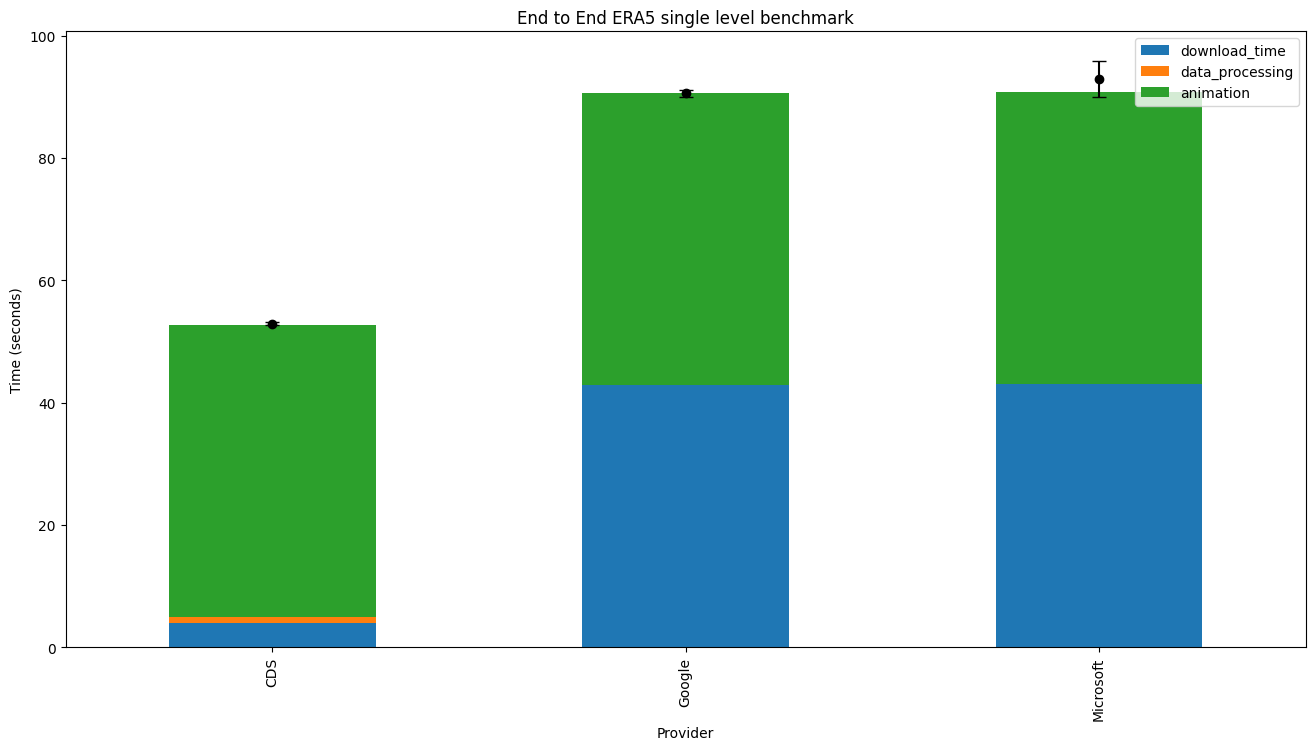

In [4]:
errors = df['end_to_end_std']
# Plotting the stacked bar chart without 'end_to_end'
df_plot = df.drop(columns=['end_to_end', 'end_to_end_std','request_issues'])
df_plot.plot(kind='bar', stacked=True, figsize=(16, 8))

# Overlay 'end_to_end' with error bars
x = np.arange(len(df))
plt.errorbar(x, df['end_to_end'], yerr=errors, fmt='o', color='black', capsize=5)

# Set labels and title
plt.ylabel('Time (seconds)')
plt.title('End to End ERA5 single level benchmark')
plt.xlabel("Provider")

# Adding city names as x-tick labels
plt.xticks(x, df['provider'])

# Display legend
plt.legend(loc='upper right')

# Save the figure
plt.show()

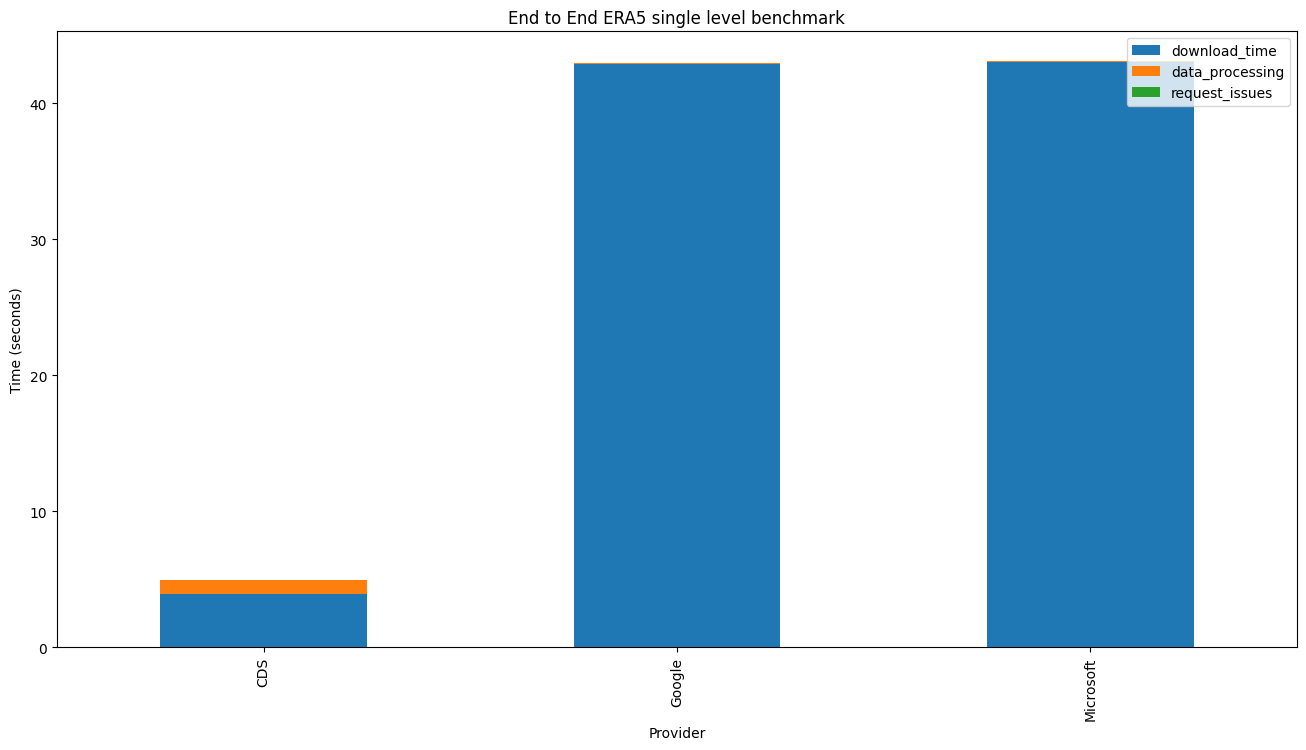

In [5]:
# Plotting the stacked bar chart without 'end_to_end'
df_plot = df.drop(columns=['end_to_end', 'end_to_end_std',"animation"])
df_plot.plot(kind='bar', stacked=True, figsize=(16, 8))
# Set labels and title
plt.ylabel('Time (seconds)')
plt.title('End to End ERA5 single level benchmark')
plt.xlabel("Provider")
# Adding city names as x-tick labels
plt.xticks(x, df['provider'])
# Display legend
plt.legend(loc='upper right')
# Save the figure
plt.show()

- Processing Time: The Climate Data Store (CDS) is approximately 10 times slower than Google Cloud Platform (GCP) and Microsoft Planetary Computer. This is primarily because CDS data needs to be opened and loaded into memory using Xarray.

- Data Access Strategy: The main difference between CDS and the other providers lies in their data access strategies. For Microsoft and Google, users directly access a Zarr dataset, allowing for immediate and efficient data manipulation. In contrast, CDS data must be downloaded and is subject to a request queue, which can introduce significant delays.

- Download Speed: Download speeds are generally faster for GCP and Microsoft compared to CDS. This discrepancy may be due to the geographical location of the CDS servers or their data delivery infrastructure.

- Animation Consistency: Animation performance is consistent across all three providers since the input data are identical.

- Data Processing: Data processing is slower with CDS because it requires the data to be read into memory using Xarray. In contrast, with Google and Microsoft, the data is directly accessible in memory through Zarr, which speeds up the processing.

## Size verification and data shape

In [6]:
from utils import (load_config, PlanetaryComputerERA5,
                    CdsERA5, GcpERA5, WindSpeedVisualizer)
import time

In [7]:
config = load_config("config.yaml")

### CDS

In [8]:
query = config["cds_request"]
start = time.time()
cds = CdsERA5()
cds.get_data(query=query)
cds.download(filename="ERA5")
wind_speed_cds, ds = cds.process()
wind_anim_cds = WindSpeedVisualizer.generate_animation(wind_speed_cds)
end = time.time()
print(f"End to End duration {end-start}")

2024-07-09 13:46:56.546 | INFO     | utils:__init__:141 - Successfully log to Climate Data Store
2024-07-09 13:46:56,648 INFO Welcome to the CDS
2024-07-09 13:46:56,649 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-07-09 13:46:56,702 INFO Request is completed
2024-07-09 13:46:56.703 | INFO     | utils:wrapper:33 - get_data ran in 0.15621137619018555 seconds
2024-07-09 13:46:56,704 INFO Downloading https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data9/adaptor.mars.internal-1720524293.2922404-2913-13-62aa85f3-3be7-42f2-8df0-13728956f836.grib to ERA5.grib (122.8M)
2024-07-09 13:47:01,714 INFO Download rate 24.5M/s 
2024-07-09 13:47:01.715 | INFO     | utils:wrapper:33 - download ran in 5.011176109313965 seconds
Ignoring index file 'ERA5.grib.9093e.idx' older than GRIB file
2024-07-09 13:47:03.324 | INFO     | utils:wrapper:33 - process ran in 1.6087698936462402 seconds
2024-07-09 13:47:50.912 | INFO

End to End duration 54.36771321296692


In [9]:
print(f"End to End duration {end-start} seconds" )
print(f"Shape of CDS dataset: {wind_speed_cds.sizes}")
print(f"CDS Dataset Size: {wind_speed_cds.nbytes / (1024*1024)} MB")

End to End duration 54.36771321296692 seconds
Shape of CDS dataset: Frozen({'time': 31, 'latitude': 721, 'longitude': 1440})
CDS Dataset Size: 122.7777099609375 MB


### GCP

In [10]:
query = config["gcp_request"]
url_dataset = query["url_dataset"]
start_date = query["start"]
end = query["end"]
frequence = query["frequence"]
variables = query["variables"]
start = time.time()
gcp = GcpERA5(url_dataset)
date_range = pd.date_range(start_date, end, freq=frequence)
gcp.get_data(date_range=date_range, variables=variables)
gcp.download()
wind_speed_gcp, ds_gcp = gcp.calculate_wind_speed()
wind_anim = WindSpeedVisualizer.generate_animation(wind_speed_gcp)
end = time.time()

2024-07-09 13:47:55.114 | INFO     | utils:__init__:190 - ERA5 reanalysis data loaded successfully from gs://gcp-public-data-arco-era5/ar/1959-2022-full_37-1h-0p25deg-chunk-1.zarr-v2
2024-07-09 13:47:55.127 | INFO     | utils:get_data:210 - Data slice selected for date range
2024-07-09 13:47:55.127 | INFO     | utils:wrapper:33 - get_data ran in 0.012389898300170898 seconds
2024-07-09 13:48:38.773 | INFO     | utils:wrapper:33 - download ran in 43.6448335647583 seconds
2024-07-09 13:48:38.844 | INFO     | utils:calculate_wind_speed:235 - Wind speed calculated successfully
2024-07-09 13:48:38.845 | INFO     | utils:wrapper:33 - calculate_wind_speed ran in 0.07121634483337402 seconds
2024-07-09 13:49:26.489 | INFO     | utils:wrapper:33 - generate_animation ran in 47.64336085319519 seconds


In [11]:
print(f"End to End duration {end-start}")
print(f"Shape of GCP dataset: {wind_speed_gcp.sizes}")
print(f"GCP Dataset Size: {wind_speed_gcp.nbytes / (1024*1024)} MB")

End to End duration 95.5658802986145
Shape of GCP dataset: Frozen({'time': 31, 'latitude': 721, 'longitude': 1440})
GCP Dataset Size: 122.7777099609375 MB


### Microsoft

In [12]:
query = config["microsoft"]
url_dataset = query["url_dataset"]
start_date = query["start"]
end = query["end"]
frequence = query["frequence"]
variables = query["variables"]
start = time.time()
pc = PlanetaryComputerERA5(url_dataset)
date_range = pd.date_range(start_date, end, freq=frequence)
variables=["northward_wind_at_10_metres","eastward_wind_at_10_metres"]
pc.get_data(date_range=date_range, variables=variables)
pc.download()
wind_speed_pc, ds_pc = pc.calculate_wind_speed()
wind_anim = WindSpeedVisualizer.generate_animation(wind_speed_pc)
end = time.time()

2024-07-09 13:49:26.669 | INFO     | utils:__init__:257 - Access to ERA5 reanalysis successfully from https://planetarycomputer.microsoft.com/api/stac/v1/
/home/ubuntu/miniconda3/envs/env/lib/python3.11/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
2024-07-09 13:49:28.796 | INFO     | utils:wrapper:33 - get_data ran in 2.1247498989105225 seconds
2024-07-09 13:50:10.372 | INFO     | utils:wrapper:33 - download ran in 41.5743191242218 seconds
2024-07-09 13:50:10.443 | INFO     | utils:calculate_wind_speed:297 - Wind speed calculated successfully from regridded dataset
2024-07-09 13:50:10.444 | INFO     | utils:wrapper:33 - calculate_wind_speed ran in 0.07119178771972656 seconds
2024-07-09 13:50:57.860 | INFO     | utils:wrapper:33 - generate_animation ran in 47.41603064537048 seconds


In [13]:
print(f"End to End duration {end-start}")
print(f"Shape of Microsoft dataset: {wind_speed_pc.sizes}")
print(f"Microsoft Dataset Size: {wind_speed_pc.nbytes / (1024*1024)} MB")

End to End duration 91.35996866226196
Shape of Microsoft dataset: Frozen({'time': 31, 'lat': 721, 'lon': 1440})
Microsoft Dataset Size: 122.7777099609375 MB
